In [87]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda")

batch_size_train = 64
batch_size_test = 1000
lr = 1
momentum = 0.7

tasks = 10

# MLP Supervised Learning (Hand-written Digit Classification)

We perform pairwise image classification on MNIST hand-written digits datastet

* 28x28 Neurons on the first layer (Flatten images)
* 512 Neurons on the hidden layer
* 2 Neurons predicting which of the two pairs the images belongs to


In [ ]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.ff1 = nn.Linear(28*28, 512)
        self.ff2 = nn.Linear(512, 10)
        self.log_softmax = F.log_softmax

    def forward(self,x):
        x = F.relu(self.ff1(x))
        x = self.log_softmax(self.ff2(x), dim=1)
        return x

### Training and Testing
Using torch dataloaders and optimizers to train and test the model using the splitted data

In [88]:
def train(model, device, train_loader, optimizer):
    model.train()
    correct = 0
    for batch_i, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        #For every batch make gradient zero
        optimizer.zero_grad()
        output = model(data)
        #Compute the negative log likelihood
        loss = F.nll_loss(output, target)
        #Backprobagate the loss
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_acc = 100. * correct / len(train_loader.dataset)
    return train_acc

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    return test_loss, test_acc

### Looking into the data
We compute the mean and std from the given dataset so that it's easier for the optimizer to compute the optimal parameters

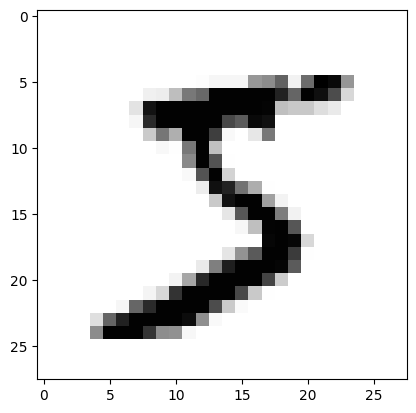

Calculated mean: 0.13066047430038452
Calculated std: 0.30810782313346863


In [90]:
tt = T.Compose([
    T.ToTensor(),
    # T.Normalize((0.1307,),(0.3081,)),
    T.Lambda(lambda x: torch.flatten(x))
])
train_df = datasets.MNIST('../data', train=True, transform=tt)

train_loader = torch.utils.data.DataLoader(train_df, batch_size=300000, shuffle=False)

mean = 0
std = 0
from fastai.vision.all import show_image

for data in train_loader:
    #Computing the mean and std of the data
    mean = data[0].mean()
    std = data[0].std()
    img_tensor = data[0][0]  # Get the first image tensor in the batch
    img = T.functional.to_pil_image(img_tensor.reshape(28,-1))  # Convert tensor to PIL image
    plt.imshow(img, cmap="Greys")  # Display the image using matplotlib
    plt.show()    
print(f"Calculated mean: {mean}")
print(f"Calculated std: {std}")

In [81]:
def first_test(model, device):
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize((0.1307),(0.3081)),
        T.Lambda(lambda x: torch.flatten(x))
    ])
    train_df = datasets.MNIST('../data', train=True, download=True, transform=transform)
    test_df = datasets.MNIST('../data', train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_df, batch_size=batch_size_train)
    test_loader = torch.utils.data.DataLoader(test_df, batch_size=batch_size_test)
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=momentum)

    for epoch in range(10):
        train_acc = train(model, device, train_loader, optimizer)
        test_loss, test_acc = test(model, device, test_loader)
        scheduler.step()
        print(f'Epoch {epoch+1} train/test accuracy: {train_acc:.2f}/{test_acc:.2f}')

model = NN().to(device)
first_test(model, device)

Epoch 1 train/test accuracy: 94.44/96.95
Epoch 2 train/test accuracy: 98.29/97.66
Epoch 3 train/test accuracy: 99.11/97.96
Epoch 4 train/test accuracy: 99.54/98.06
Epoch 5 train/test accuracy: 99.75/98.04
Epoch 6 train/test accuracy: 99.83/98.15
Epoch 7 train/test accuracy: 99.88/98.20
Epoch 8 train/test accuracy: 99.91/98.29
Epoch 9 train/test accuracy: 99.92/98.33
Epoch 10 train/test accuracy: 99.92/98.34


In [93]:
# Pairwise continual learning function
def pairwise_continual_learning(model, device, pairs):
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize((0.1307,), (0.3081,)),
        T.Lambda(lambda x: torch.flatten(x))
    ])
    overall_train_acc = []
    overall_test_acc = []

    
    pairs = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 0)]
    for pair in pairs:
        digit1, digit2 = pair
        
        # Prepare data loaders for the current pair
        train_df = datasets.MNIST('../data', train=True, download=True, transform=transform)
        test_df = datasets.MNIST('../data', train=False, download=True, transform=transform)
        
        train_indices = ((train_df.targets == digit1) | (train_df.targets == digit2))
        test_indices = ((test_df.targets == digit1) | (test_df.targets == digit2))
        
        train_df.targets = train_df.targets[train_indices]
        train_df.data = train_df.data[train_indices]
        test_df.targets = test_df.targets[test_indices]
        test_df.data = test_df.data[test_indices]

        train_loader = torch.utils.data.DataLoader(train_df, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_df, batch_size=batch_size, shuffle=False)
        
        # Define optimizer and scheduler
        optimizer = optim.Adadelta(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=momentum)
        
        # Train and test on current pair
        for epoch in range(5):  # Training each pair for 5 epochs
            train_acc = train(model, device, train_loader, optimizer)
            test_loss, test_acc = test(model, device, test_loader)
            scheduler.step()
            print(f'Pair {digit1}-{digit2}, Epoch {epoch+1}, Train Acc: {train_acc:.2f}, Test Acc: {test_acc:.2f}')
        
        overall_train_acc.append(train_acc)
        overall_test_acc.append(test_acc)
        
        # Freeze model parameters after training on current pair
        for param in model.parameters():
            param.requires_grad = False
        
    return overall_train_acc, overall_test_acc

In [ ]:
model = NN().to(device)

pairwise_continual_learning(model, device, pairs)